# Interpretable Modelling of Credit Risk

As detailed in Cynthia Rudin's excellent commentary on interpretability [(ArXiV version here)](https://arxiv.org/abs/1811.10154), there are a plethora of reasons to avoid the use of black box models when models are being used to make high stakes decisions to may have life-altering effects on real people. Efforts to develop "explainable black box models," while appealing for their potential to let us continuing using the same tools we always have and to creation explanations after the fact, are inherently flawed. As Rudin notes in my single favorite passage from her paper:

> Explainable ML methods provide explanations that are not faithful to what the original model computes. Explanations must be wrong. They cannot have perfect fidelity with respect to the original model. If the explanation was completely faithful to what the original model computes, the explanation would equal the original model, and one would not need the original model in the first place, only the explanation. (In other words, this is a case where the original model would be interpretable.) This leads to the danger that any explanation method for a black box model can be an inaccurate representation of the original model in parts of the feature space.
>
> An inaccurate (low-fidelity) explanation model limits trust in the explanation, and by extension, trust in the black box that it is trying to explain. An explainable model that has a 90% agreement with the original model indeed explains the original model most of the time. However, an explanation model that is correct 90% of the time is wrong 10% of the time. If a tenth of the explanations are incorrect, one cannot trust the explanations, and thus one cannot trust the original black box. If we cannot know for certain whether our explanation is correct, we cannot know whether to trust either the explanation or the original model.

With this motivation in mind, in this exercise, we will use a cutting edge interpretable modeling framework to model credit risk using data from the [14th Pacific-Asia Knowledge Discovery and Data Mining conference (PAKDD 2010)](https://pakdd.org/archive/pakdd2010/). This data covers the period of 2006 to 2009, and "comes from a private label credit card operation of a Brazilian credit company and its partner shops." (The competition was won by [TIMi](https://timi.eu/blog/news/timi-top-winner-at-the-pakdd-2010-cup/), who purely by coincidence helped me complete my PhD dissertation research!).

We will be working with Generalized Additive Models (GAMs) (not to be confused with Generalized *Linear* Models (GLMs) — GLMs are a special case of GAMs). In particular, we will be using the [pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html), though this is far from the only GAM implementation out there. [mvgam](https://nicholasjclark.github.io/mvgam/) in R is probably considered the gold standard, as it was developed by a pioneering researcher of GAMs. `statsmodels` also has [an implementation](https://www.statsmodels.org/stable/gam.html), and GAM is also hiding in plain sight behind many other tools, like Meta's [Prophet](https://facebook.github.io/prophet/) time series forecasting library (which is GAM-based).

## Data Prep

### Exercise 1

The PADD 2010 data is in [this repository](https://github.com/nickeubank/MIDS_Data/tree/master/PAKDD%202010). You can find column names in `PAKDD2010_VariablesList.XLS` and the actual data in `PAKDD2010_Modeling_Data.txt`.

Note: you may run into a string-encoding issue loading the `PAKDD2010_Modeling_Data.txt` data. All I'll say is that most latin-based languages used `latin8` as a text encoding prior to broad adoption of UTF-8. (Don't know about UTF? [Check out this video](https://www.youtube.com/watch?v=MijmeoH9LT4)!)

Load the data (including column names).

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
pd.set_option("mode.copy_on_write", True)

url = (
    "https://media.githubusercontent.com/media/nickeubank/"
    "MIDS_Data/master/PAKDD%202010/"
    "PAKDD2010_Modeling_Data.txt"
)


model_data = pd.read_csv(url, header=None, delimiter="\t", encoding="latin1")
model_data.columns = [
    "ID_CLIENT",
    "CLERK_TYPE",
    "PAYMENT_DAY",
    "APPLICATION_SUBMISSION_TYPE",
    "QUANT_ADDITIONAL_CARDS",
    "POSTAL_ADDRESS_TYPE",
    "SEX",
    "MARITAL_STATUS",
    "QUANT_DEPENDANTS",
    "EDUCATION_LEVEL",
    "STATE_OF_BIRTH",
    "CITY_OF_BIRTH",
    "NACIONALITY",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "FLAG_RESIDENCIAL_PHONE",
    "RESIDENCIAL_PHONE_AREA_CODE",
    "RESIDENCE_TYPE",
    "MONTHS_IN_RESIDENCE",
    "FLAG_MOBILE_PHONE",
    "FLAG_EMAIL",
    "PERSONAL_MONTHLY_INCOME",
    "OTHER_INCOMES",
    "FLAG_VISA",
    "FLAG_MASTERCARD",
    "FLAG_DINERS",
    "FLAG_AMERICAN_EXPRESS",
    "FLAG_OTHER_CARDS",
    "QUANT_BANKING_ACCOUNTS",
    "QUANT_SPECIAL_BANKING_ACCOUNTS",
    "PERSONAL_ASSETS_VALUE",
    "QUANT_CARS",
    "COMPANY",
    "PROFESSIONAL_STATE",
    "PROFESSIONAL_CITY",
    "PROFESSIONAL_BOROUGH",
    "FLAG_PROFESSIONAL_PHONE",
    "PROFESSIONAL_PHONE_AREA_CODE",
    "MONTHS_IN_THE_JOB",
    "PROFESSION_CODE",
    "OCCUPATION_TYPE",
    "MATE_PROFESSION_CODE",
    "EDUCATION_LEVEL",
    "FLAG_HOME_ADDRESS_DOCUMENT",
    "FLAG_RG",
    "FLAG_CPF",
    "FLAG_INCOME_PROOF",
    "PRODUCT",
    "FLAG_ACSP_RECORD",
    "AGE",
    "RESIDENCIAL_ZIP_3",
    "PROFESSIONAL_ZIP_3",
    "TARGET_LABEL_BAD=1",
]
model_data.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


In [2]:
# Find duplicated values in the EDUCATION_LEVEL column
duplicated_mask = model_data["EDUCATION_LEVEL"].duplicated(keep=False)

In [3]:
# Create a copy of the columns as a list to manipulate
columns_list = model_data.columns.tolist()

# Find the indices of the "EDUCATION_LEVEL" columns
education_level_indices = [
    i for i, col in enumerate(columns_list) if col == "EDUCATION_LEVEL"
]

# Rename the columns directly based on their indices
columns_list[education_level_indices[0]] = "EDUCATION_LEVEL_1"
columns_list[education_level_indices[1]] = "EDUCATION_LEVEL_2"

# Assign the modified list back to the DataFrame's columns
model_data.columns = columns_list

# Display the first few rows to verify the changes
model_data.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL_1,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


In [4]:
# look at all the distribution

# Check the distribution of "EDUCATION_LEVEL_1"
education_level_1_distribution = model_data["EDUCATION_LEVEL_1"].value_counts()

# Check the distribution of "EDUCATION_LEVEL_2"
education_level_2_distribution = model_data["EDUCATION_LEVEL_2"].value_counts()

# Display the distributions
print("EDUCATION_LEVEL_1 Distribution:\n", education_level_1_distribution)
print("\nEDUCATION_LEVEL_2 Distribution:\n", education_level_2_distribution)

EDUCATION_LEVEL_1 Distribution:
 0    50000
Name: EDUCATION_LEVEL_1, dtype: int64

EDUCATION_LEVEL_2 Distribution:
 0.0    15995
3.0      621
4.0      615
2.0      342
1.0       56
5.0       33
Name: EDUCATION_LEVEL_2, dtype: int64


>Given the constant value in ``EDUCATION_LEVEL_1``, we will drop it becauase of all the missing value. ``EDUCATION_LEVEL_`` seems to have meaningful variation that could be relevant for understanding patterns or for use in predictive modeling, so we will keep it.

In [5]:
# drop EDUCATION_LEVEL_1
model_data = model_data.drop(columns=["EDUCATION_LEVEL_1"])

model_data.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,STATE_OF_BIRTH,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,RN,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,RJ,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,RN,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,PE,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,RJ,...,0,0,0,0,1,N,48,235,235,1


### Exercise 2

There are a few variables with a lot of missing values (more than half missing). Given the limited documentation for this data it's a little hard to be sure why, but given the effect on sample size and what variables are missing, let's go ahead and drop them. You you end up dropping 6 variables.

Hint: Some variables have missing values that aren't immediately obviously.

(This is not strictly necessary at this stage, given we'll be doing more feature selection down the line, but keeps things easier knowing we don't have to worry about missingness later.)

In [6]:
# dealing with all missing values
import numpy as np

model_data["APPLICATION_SUBMISSION_TYPE"] = model_data[
    "APPLICATION_SUBMISSION_TYPE"
].replace("0", np.nan)
model_data["SEX"] = model_data["SEX"].replace(["N", " "], np.nan)
model_data["MARITAL_STATUS"] = model_data["MARITAL_STATUS"].replace(0, np.nan)
model_data["OCCUPATION_TYPE"] = model_data["OCCUPATION_TYPE"].replace(0.0, np.nan)
model_data["RESIDENCE_TYPE"] = model_data["RESIDENCE_TYPE"].replace(0.0, np.nan)
model_data["RESIDENCIAL_ZIP_3"] = model_data["RESIDENCIAL_ZIP_3"].replace(
    "#DIV/0!", np.nan
)
model_data["PROFESSIONAL_STATE"] = model_data["PROFESSIONAL_STATE"].replace(" ", np.nan)
model_data["PROFESSIONAL_PHONE_AREA_CODE"] = model_data[
    "PROFESSIONAL_PHONE_AREA_CODE"
].replace(" ", np.nan)

In [7]:
model_data["OCCUPATION_TYPE"].unique()

array([ 4., nan,  5.,  2.,  1.,  3.])

In [8]:
drop_missing = model_data.isnull().sum() / len(model_data)

In [9]:
columns_to_drop = drop_missing[drop_missing > 0.5].index.tolist()
columns_to_drop

['PROFESSIONAL_STATE',
 'PROFESSIONAL_CITY',
 'PROFESSIONAL_BOROUGH',
 'PROFESSIONAL_PHONE_AREA_CODE',
 'MATE_PROFESSION_CODE',
 'EDUCATION_LEVEL_2']

> In this case, the 6 columns including ``PROFESSIONAL_CITY``, ``PROFESSIONAL_BOROUGH``,``MATE_PROFESSION_CODE``,``EDUCATION_LEVEL_2``, ``PROFESSIONAL_STATE``, and ``PROFESSIONAL_PHONE_AREA_CODE`` were dropped due to over half proportions of missing values.

### Exercise 3

Let's start off by fitting a model that uses the following variables:

```
"QUANT_DEPENDANTS",
"QUANT_CARS",
"MONTHS_IN_RESIDENCE",
"PERSONAL_MONTHLY_INCOME",
"QUANT_BANKING_ACCOUNTS",
"AGE",
"SEX",
"MARITAL_STATUS",
"OCCUPATION_TYPE",
"RESIDENCE_TYPE",
"RESIDENCIAL_STATE",
"RESIDENCIAL_CITY",
"RESIDENCIAL_BOROUGH",
"RESIDENCIAL_ZIP_3"
```

(GAMs don't have any automatic feature selection methods, so these are based on my own sense of features that are likely to matter. A fully analysis would entail a few passes at feature refinement)

Plot and otherwise characterize the distributions of all the variables we may use. If you see anything bananas, adjust how terms enter your model. Yes, pyGAM has flexible functional forms, but giving the model features that are engineered to be more substantively meaningful (e.g., taking log of income) will aid model estimation. 

You should probably do something about the functional form of *at least* `PERSONAL_MONTHLY_INCOME`, and `QUANT_DEPENDANTS`.

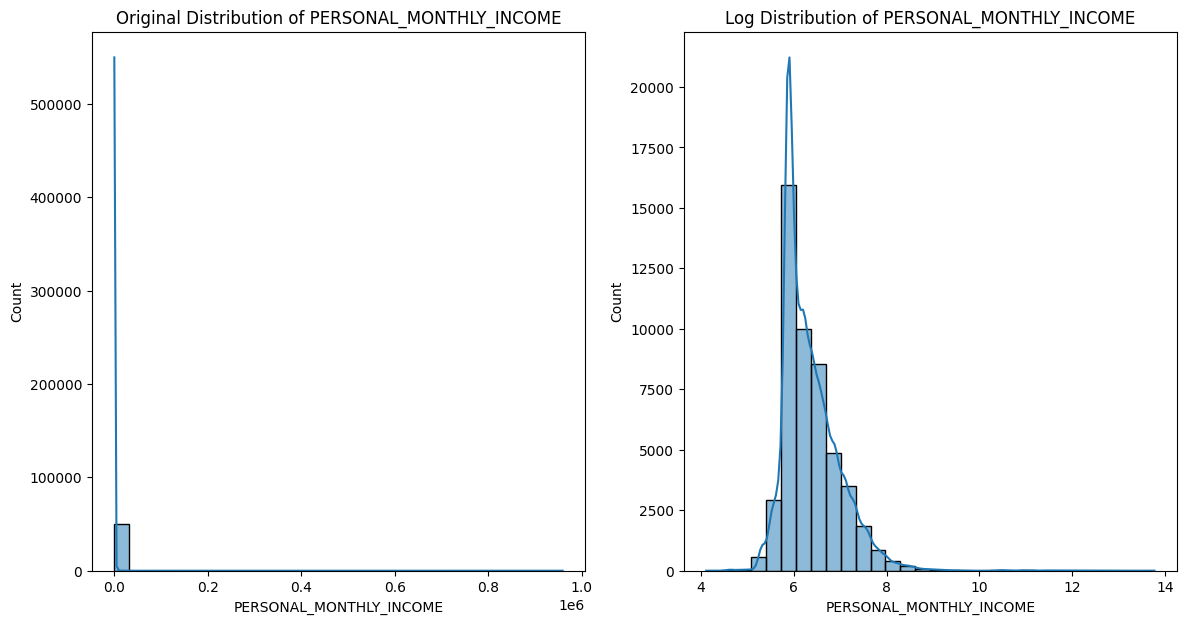

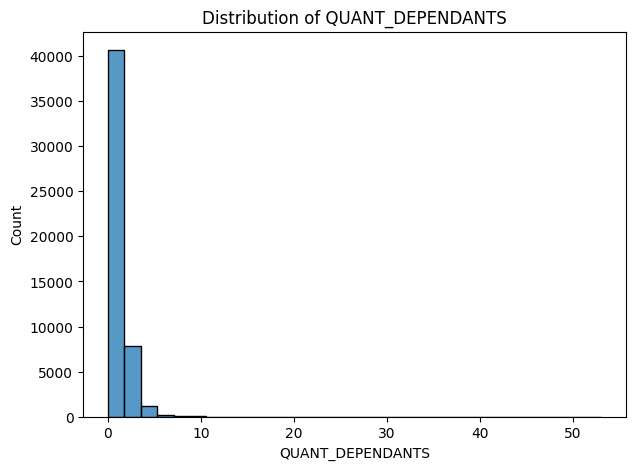

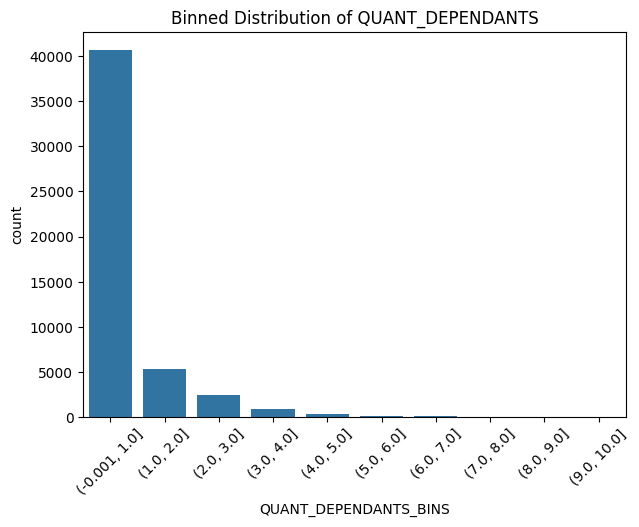

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# plot the two variables with hint

# Apply a log transformation to 'PERSONAL_MONTHLY_INCOME'
model_data["LOG_PERSONAL_MONTHLY_INCOME"] = np.log1p(
    model_data["PERSONAL_MONTHLY_INCOME"].copy()
)

# Define the binned categories for 'QUANT_DEPENDANTS'
bins = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
]
model_data["QUANT_DEPENDANTS_BINS"] = pd.cut(
    model_data["QUANT_DEPENDANTS"], bins=bins, include_lowest=True
)

# Ensure 'PERSONAL_MONTHLY_INCOME' is converted to a mutable format
model_data["PERSONAL_MONTHLY_INCOME"] = model_data["PERSONAL_MONTHLY_INCOME"].astype(
    float
)

# Plotting the original distribution
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.histplot(model_data["PERSONAL_MONTHLY_INCOME"], bins=30, kde=True)
plt.title("Original Distribution of PERSONAL_MONTHLY_INCOME")

# Plotting the log-transformed distribution
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(model_data["PERSONAL_MONTHLY_INCOME"]), bins=30, kde=True)
plt.title("Log Distribution of PERSONAL_MONTHLY_INCOME")
plt.show()


# Plotting the 'QUANT_DEPENDANTS' distribution
plt.figure(figsize=(7, 5))
sns.histplot(model_data["QUANT_DEPENDANTS"], bins=30, kde=False)
plt.title("Distribution of QUANT_DEPENDANTS")
plt.show()

# Plotting the binned 'QUANT_DEPENDANTS'
plt.figure(figsize=(7, 5))
sns.countplot(x="QUANT_DEPENDANTS_BINS", data=model_data)
plt.title("Binned Distribution of QUANT_DEPENDANTS")
plt.xticks(rotation=45)
plt.show()

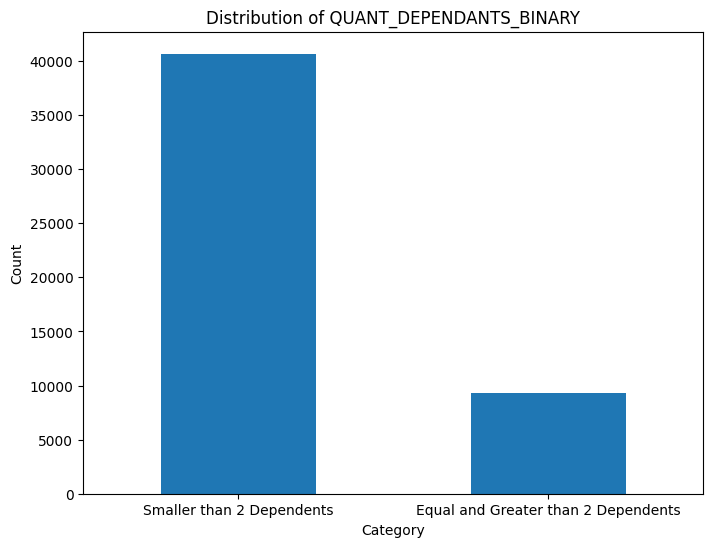

In [11]:
# Create a binary variable based on the threshold
model_data["QUANT_DEPENDANTS_BINARY"] = model_data["QUANT_DEPENDANTS"].apply(
    lambda x: 1 if x >= 2 else 0
)

# Plotting the distribution of 'QUANT_DEPENDANTS_BINARY'
plt.figure(figsize=(8, 6))
model_data["QUANT_DEPENDANTS_BINARY"].value_counts().plot(kind="bar")
plt.title("Distribution of QUANT_DEPENDANTS_BINARY")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(
    ticks=[0, 1],
    labels=["Smaller than 2 Dependents", "Equal and Greater than 2 Dependents"],
    rotation=0,
)
plt.show()

In [12]:
# check data type
columns_of_interest = [
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "RESIDENCIAL_ZIP_3",
]

model_data[columns_of_interest].dtypes

QUANT_CARS                  int64
MONTHS_IN_RESIDENCE       float64
QUANT_BANKING_ACCOUNTS      int64
AGE                         int64
SEX                        object
MARITAL_STATUS            float64
OCCUPATION_TYPE           float64
RESIDENCE_TYPE            float64
RESIDENCIAL_STATE          object
RESIDENCIAL_CITY           object
RESIDENCIAL_BOROUGH        object
RESIDENCIAL_ZIP_3          object
dtype: object

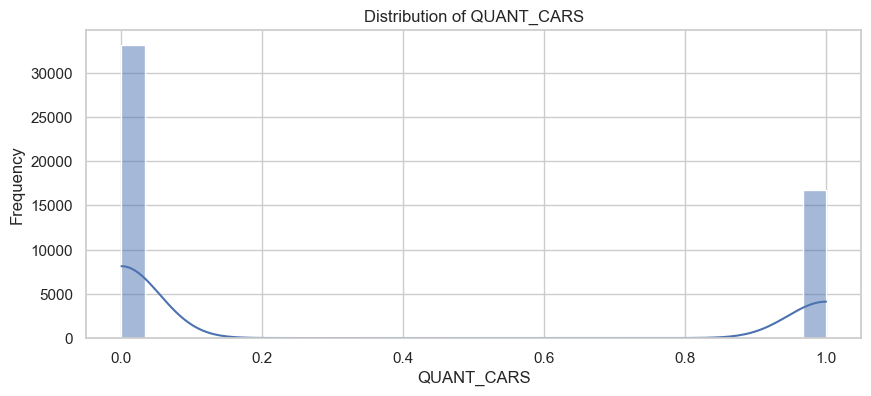

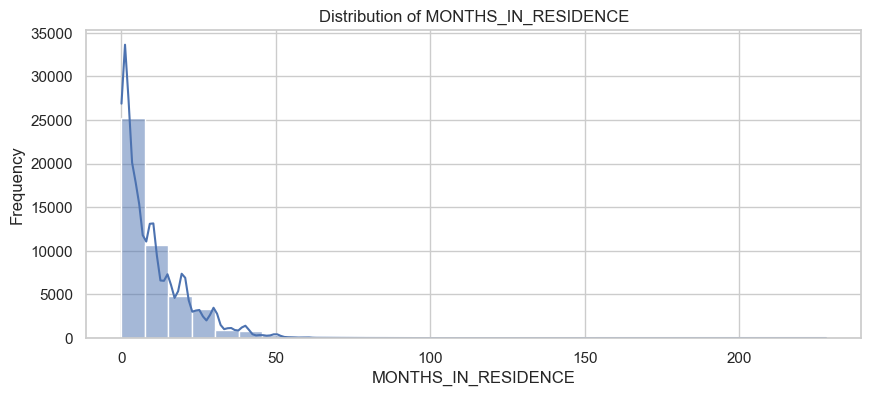

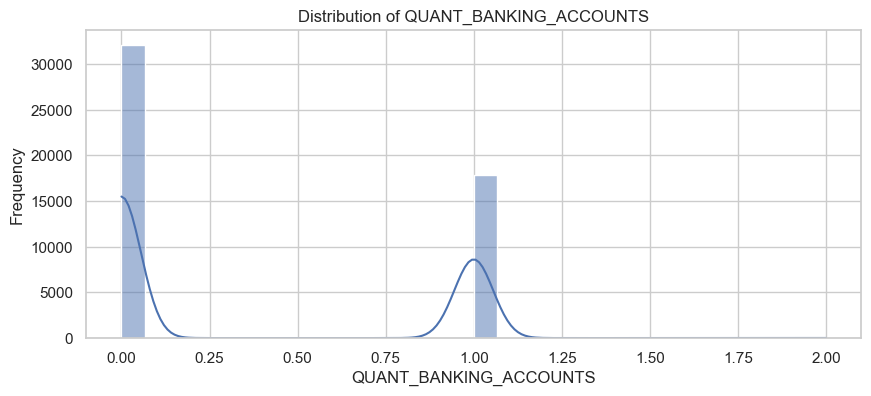

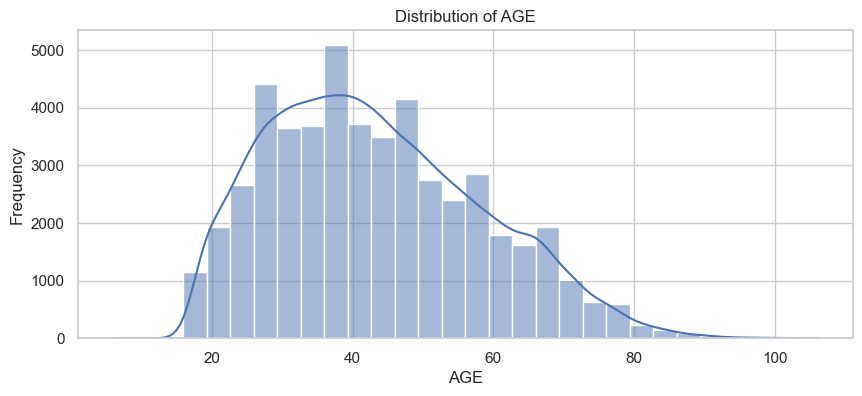

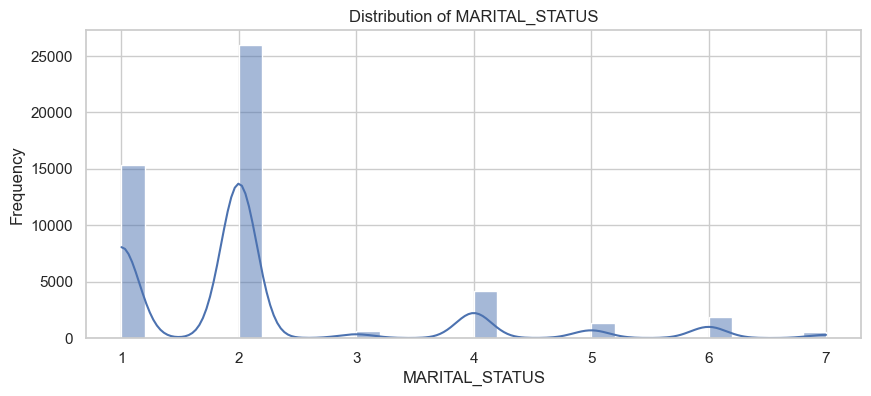

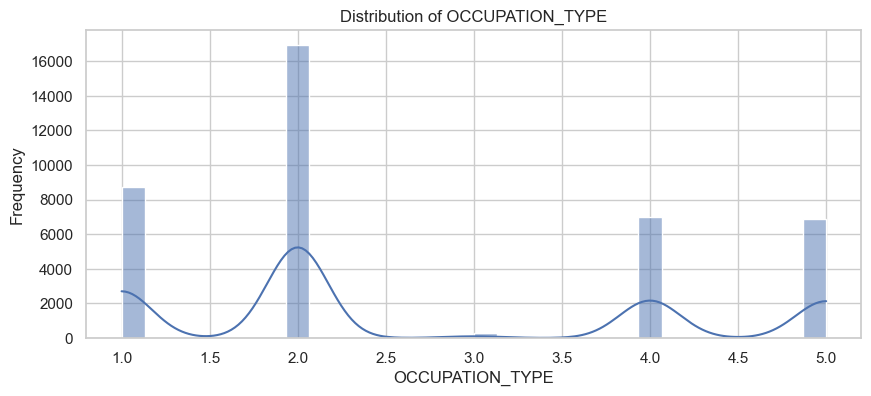

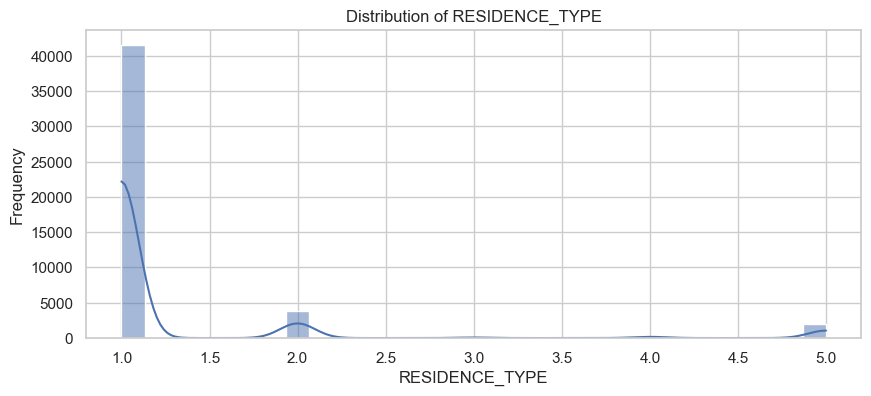

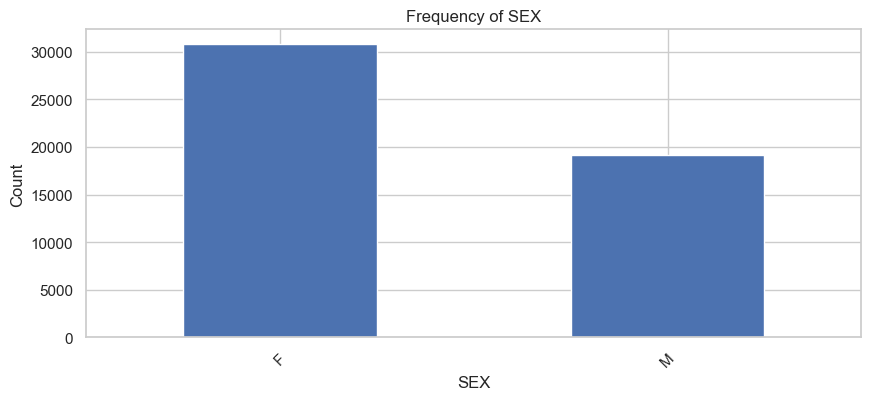

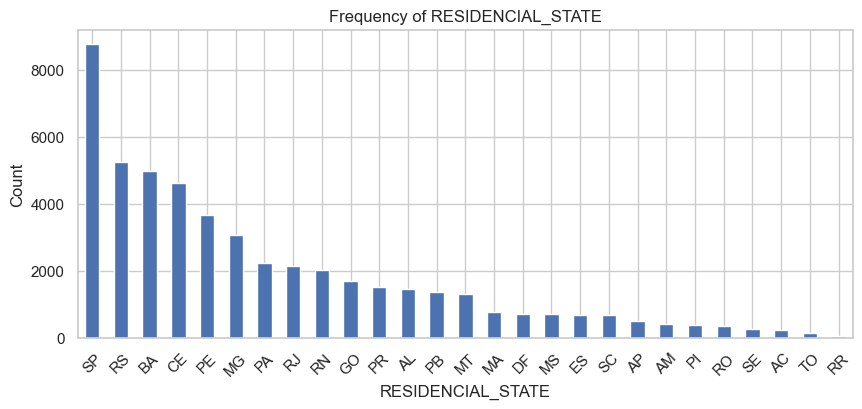

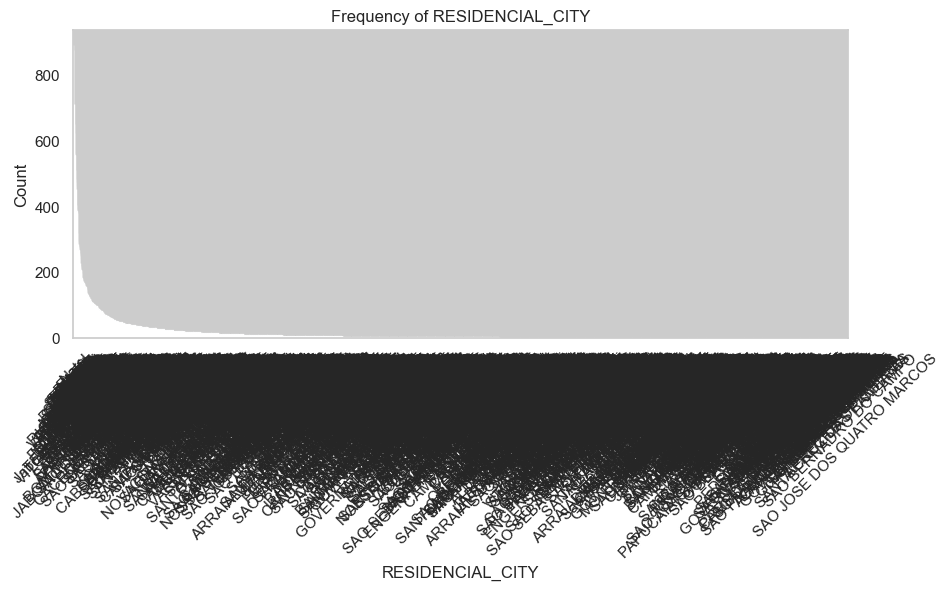

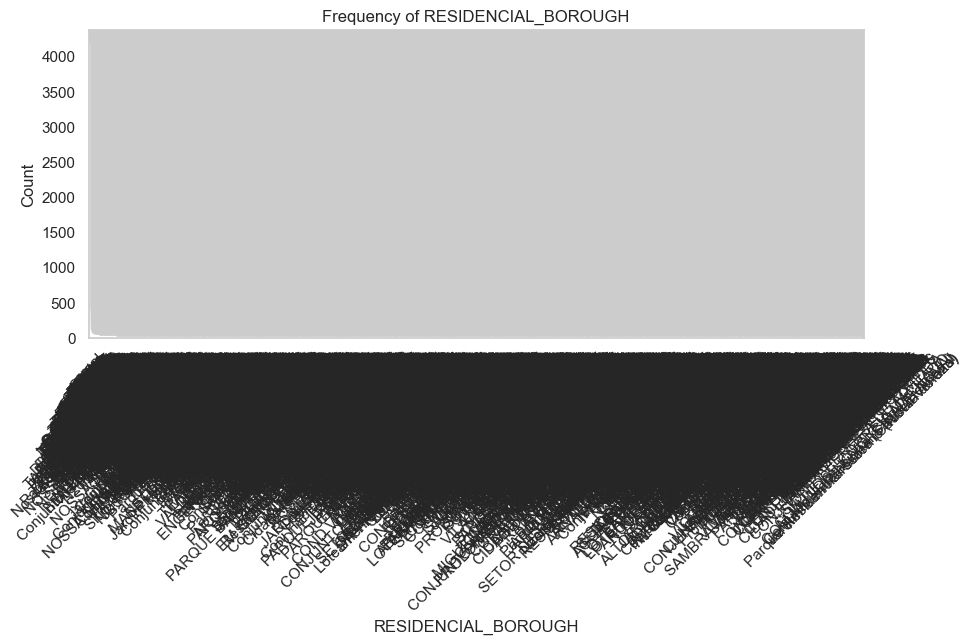

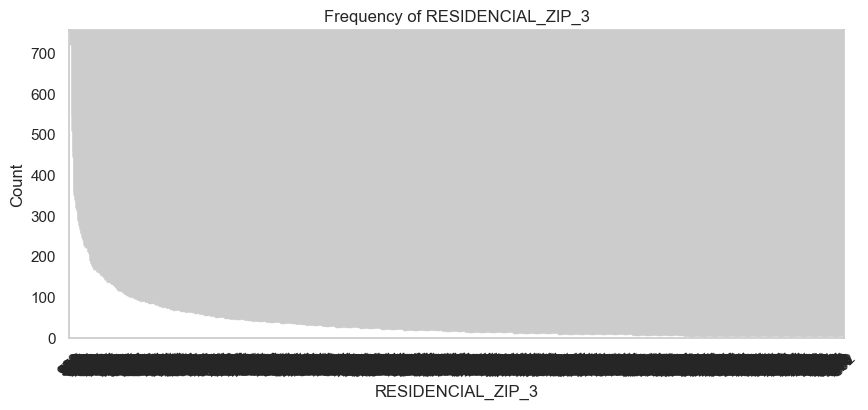

In [13]:
# plot the rest of the 12 variabales

# Setting up the plotting environment
sns.set(style="whitegrid")

# List of numerical and categorical variables
numerical_vars = [
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
]
categorical_vars = [
    "SEX",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "RESIDENCIAL_ZIP_3",
]

# Plotting numerical variables using histograms
for var in numerical_vars:
    plt.figure(figsize=(10, 4))
    sns.histplot(model_data[var], kde=True, bins=30)
    plt.title(f"Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.show()

# Plotting categorical variables using bar plots
for var in categorical_vars:
    plt.figure(figsize=(10, 4))
    model_data[var].value_counts().plot(kind="bar")
    plt.title(f"Frequency of {var}")
    plt.xlabel(var)
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.show()

>By ploting all the variables, we logged the ``PERSONAL_MONTHLY_INCOME`` , binned and converted ``QUANT_DEPENDANTS`` as a binary variable, making them more symmetrical and potentially more suitable for modeling, .

### Exercise 4

Geographic segregation means residency data often contains LOTS of information. But there's a problem with `RESIDENCIAL_CITY` and `RESIDENCIAL_BOROUGH`. What is the problem?

In any real project, this would be something absolutely worth resolving, but for this exercise, we'll just drop all three string `RESIDENCIAL_` variables.

>While ``RESIDENCIAL_CITY`` and ``RESIDENCIAL_BOROUGH`` can provide valuable information for understanding geographic patterns and segregation, their high cardinality and the presence of spatial autocorrelation present challenges that need to be addressed to improve model performance and interpretability.

In [14]:
# Dropping the 'RESIDENCIAL_STATE', 'RESIDENCIAL_CITY', and 'RESIDENCIAL_BOROUGH' columns
model_data = model_data.drop(
    ["RESIDENCIAL_STATE", "RESIDENCIAL_CITY", "RESIDENCIAL_BOROUGH"], axis=1
)

# Verify the columns are dropped
print(model_data.columns)

Index(['ID_CLIENT', 'CLERK_TYPE', 'PAYMENT_DAY', 'APPLICATION_SUBMISSION_TYPE',
       'QUANT_ADDITIONAL_CARDS', 'POSTAL_ADDRESS_TYPE', 'SEX',
       'MARITAL_STATUS', 'QUANT_DEPENDANTS', 'STATE_OF_BIRTH', 'CITY_OF_BIRTH',
       'NACIONALITY', 'FLAG_RESIDENCIAL_PHONE', 'RESIDENCIAL_PHONE_AREA_CODE',
       'RESIDENCE_TYPE', 'MONTHS_IN_RESIDENCE', 'FLAG_MOBILE_PHONE',
       'FLAG_EMAIL', 'PERSONAL_MONTHLY_INCOME', 'OTHER_INCOMES', 'FLAG_VISA',
       'FLAG_MASTERCARD', 'FLAG_DINERS', 'FLAG_AMERICAN_EXPRESS',
       'FLAG_OTHER_CARDS', 'QUANT_BANKING_ACCOUNTS',
       'QUANT_SPECIAL_BANKING_ACCOUNTS', 'PERSONAL_ASSETS_VALUE', 'QUANT_CARS',
       'COMPANY', 'PROFESSIONAL_STATE', 'PROFESSIONAL_CITY',
       'PROFESSIONAL_BOROUGH', 'FLAG_PROFESSIONAL_PHONE',
       'PROFESSIONAL_PHONE_AREA_CODE', 'MONTHS_IN_THE_JOB', 'PROFESSION_CODE',
       'OCCUPATION_TYPE', 'MATE_PROFESSION_CODE', 'EDUCATION_LEVEL_2',
       'FLAG_HOME_ADDRESS_DOCUMENT', 'FLAG_RG', 'FLAG_CPF',
       'FLAG_INCOME_PRO

## Model Fitting

### Exercise 5

First, use `train_test_split` to do an 80/20 split of your data. Then, using the `TARGET_LABEL_BAD` variable, fit a classification model on this data. Optimize with `gridsearch`. Use splines for continuous variables and factors for categoricals.

At this point we'd *ideally* be working with 11 variables. However pyGAM can get a little slow with factor features with lots of values + lots of unique values (e.g., 50,000 observations and the *many* values of `RESIDENCIAL_ZIP` takes about 15 minutes on my computer). In that configuration, you should get a model fit in 10-15 seconds.

So let's start by fitting a model that also excludes `RESIDENCIAL_ZIP`.

In [15]:
# check data type

potentail_model_var = [
    "QUANT_DEPENDANTS_BINARY",
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "LOG_PERSONAL_MONTHLY_INCOME",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "TARGET_LABEL_BAD=1",
]

model_data = model_data[potentail_model_var]

In [16]:
model_data[potentail_model_var].isnull().sum()

QUANT_DEPENDANTS_BINARY            0
QUANT_CARS                         0
MONTHS_IN_RESIDENCE             3777
LOG_PERSONAL_MONTHLY_INCOME        0
QUANT_BANKING_ACCOUNTS             0
AGE                                0
SEX                               65
MARITAL_STATUS                   202
OCCUPATION_TYPE                10101
RESIDENCE_TYPE                  2109
TARGET_LABEL_BAD=1                 0
dtype: int64

In [17]:
numerical_vars = [
    "QUANT_DEPENDANTS_BINARY",
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "LOG_PERSONAL_MONTHLY_INCOME",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
]

num_missing = model_data[numerical_vars].isnull().sum()
num_missing

QUANT_DEPENDANTS_BINARY            0
QUANT_CARS                         0
MONTHS_IN_RESIDENCE             3777
LOG_PERSONAL_MONTHLY_INCOME        0
QUANT_BANKING_ACCOUNTS             0
AGE                                0
MARITAL_STATUS                   202
OCCUPATION_TYPE                10101
RESIDENCE_TYPE                  2109
dtype: int64

In [18]:
model_data = model_data.dropna()

In [19]:
# List of columns to convert to categorical variables
to_cat = [
    "QUANT_DEPENDANTS_BINARY",
    "QUANT_CARS",
    "QUANT_BANKING_ACCOUNTS",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
]

# Convert columns to categorical type
for column in to_cat:
    model_data[column] = model_data[column].astype("category")

In [20]:
print(model_data.dtypes)

QUANT_DEPENDANTS_BINARY        category
QUANT_CARS                     category
MONTHS_IN_RESIDENCE             float64
LOG_PERSONAL_MONTHLY_INCOME     float64
QUANT_BANKING_ACCOUNTS         category
AGE                               int64
SEX                            category
MARITAL_STATUS                 category
OCCUPATION_TYPE                category
RESIDENCE_TYPE                 category
TARGET_LABEL_BAD=1                int64
dtype: object


In [21]:
# numarical var
to_num_var = ["MONTHS_IN_RESIDENCE", "LOG_PERSONAL_MONTHLY_INCOME", "AGE"]

In [22]:
model_data

,QUANT_DEPENDANTS_BINARY,QUANT_CARS,MONTHS_IN_RESIDENCE,LOG_PERSONAL_MONTHLY_INCOME,QUANT_BANKING_ACCOUNTS,AGE,SEX,MARITAL_STATUS,OCCUPATION_TYPE,RESIDENCE_TYPE,TARGET_LABEL_BAD=1
0,0,0,15.0,6.803505,0,32,F,6.0,4.0,1.0,1
1,0,0,1.0,6.621406,0,34,F,2.0,4.0,1.0,1
4,0,0,12.0,7.090910,0,48,M,2.0,5.0,1.0,1
5,0,1,4.0,6.216606,1,40,M,2.0,2.0,1.0,1
6,1,0,1.0,5.771441,0,40,F,2.0,4.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
49993,0,1,4.0,7.003974,1,44,F,2.0,3.0,1.0,1
49994,1,0,38.0,5.910797,1,38,F,2.0,2.0,1.0,1
49995,1,1,14.0,7.280697,1,36,F,1.0,4.0,1.0,1
49997,1,0,5.0,7.349874,0,41,M,2.0,2.0,2.0,0


In [23]:
# Perform an 80/20 train-test split
from sklearn.model_selection import train_test_split

X = model_data.loc[:, model_data.columns != "TARGET_LABEL_BAD=1"]
y = model_data["TARGET_LABEL_BAD=1"]

# Perform an 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29599 entries, 24651 to 21349
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   QUANT_DEPENDANTS_BINARY      29599 non-null  category
 1   QUANT_CARS                   29599 non-null  category
 2   MONTHS_IN_RESIDENCE          29599 non-null  float64 
 3   LOG_PERSONAL_MONTHLY_INCOME  29599 non-null  float64 
 4   QUANT_BANKING_ACCOUNTS       29599 non-null  category
 5   AGE                          29599 non-null  int64   
 6   SEX                          29599 non-null  category
 7   MARITAL_STATUS               29599 non-null  category
 8   OCCUPATION_TYPE              29599 non-null  category
 9   RESIDENCE_TYPE               29599 non-null  category
dtypes: category(7), float64(2), int64(1)
memory usage: 1.1 MB


In [25]:
# fit the model
from pygam import LogisticGAM, s, f

from pygam.datasets import default

# Convert categorical variables in X_train and X_test to their category codes
for column in to_cat:
    X_train[column] = X_train[column].cat.codes
    X_test[column] = X_test[column].cat.codes

# Convert X_train and y_train to NumPy arrays
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

X, y = default(return_X_y=True)

gam = LogisticGAM(
    f(0) + f(1) + s(2) + s(3) + f(4) + s(5) + f(6) + f(7) + f(8) + f(9)  # 3 s
).gridsearch(X_train_np, y_train_np)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:01 ETA:   0:00:19
 18% (2 of 11) |####                     | Elapsed Time: 0:00:03 ETA:   0:00:14
 27% (3 of 11) |######                   | Elapsed Time: 0:00:04 ETA:   0:00:08
 36% (4 of 11) |#########                | Elapsed Time: 0:00:05 ETA:   0:00:07
 45% (5 of 11) |###########              | Elapsed Time: 0:00:06 ETA:   0:00:07
 54% (6 of 11) |#############            | Elapsed Time: 0:00:07 ETA:   0:00:05
 63% (7 of 11) |###############          | Elapsed Time: 0:00:08 ETA:   0:00:04
 72% (8 of 11) |##################       | Elapsed Time: 0:00:10 ETA:   0:00:03
 81% (9 of 11) |####################     | Elapsed Time: 0:00:11 ETA:   0:00:02
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:12 ETA:   0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


In [26]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     28.0796
Link Function:                        LogitLink Log Likelihood:                                -16648.1257
Number of Samples:                        29599 AIC:                                            33352.4106
                                                AICc:                                           33352.4698
                                                UBRE:                                               3.1276
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0175
Feature Function                  Lam

In [27]:
# check accuracy
X_test_np = X_test.to_numpy()
accuracy = gam.accuracy(X_test_np, y_test.to_numpy())
print("Model accuracy:", accuracy)

Model accuracy: 0.7398648648648649


### Exercise 6

Create a (naive) confusion matrix using the predicted values you get with `predict()` on your test data. Our stakeholder cares about two things: 

- maximizing the number of people to whom they extend credit, and
- the false negative rate (the share of people identified as "safe bets" who aren't, and who thus default).

How many "good bets" does the model predict (true negatives), and what is the [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives)?

Looking at the confusion matrix, how did the model maximize accuracy?

In [28]:
from sklearn.metrics import confusion_matrix

# Use the trained model to predict labels for the test data
y_pred = gam.predict(X_test)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract true negatives (TN) and false negatives (FN) from the confusion matrix
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

# Calculate False Omission Rate (FOR)
FOR = FN / (FN + TN)

# Calculate the number of "good bets" (true negatives)
good_bets = TN

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nNumber of 'good bets' (True Negatives):", good_bets)
print("False Omission Rate (FOR):", FOR)

Confusion Matrix:
[[5474    1]
 [1924    1]]

Number of 'good bets' (True Negatives): 5474
False Omission Rate (FOR): 0.2600702892673696


>With the chosen threshold, the model has successfully maximized the number of individuals to whom credit is extended, as evidenced by a high number of true negatives (5474). This means the model is effectively identifying a large number of people as "safe" to lend to. However, the False Omission Rate (FOR) of 0.260 suggests that about 26% of those identified as "safe bets" actually represent a risk of default. This indicates a significant proportion of individuals deemed low-risk could potentially default, highlighting a concern in accurately identifying true "safe bets.

### Exercise 7

Suppose your stakeholder wants to minimize false negative rates. How low of a [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives) can you get (assuming more than, say, 10 true negatives), and how many "good bets" (true negatives) do they get at that risk level?

Hint: use `predict_proba()`

Note: One *can* use class weights to shift the emphasis of the original model fitting, but for the moment let's just play with `predict_proba()` and thresholds.

In [43]:
# Get predicted probabilities for the positive class (default)
predicted_probabilities = gam.predict_proba(X_test)

# Extract probabilities for the positive class
positive_probabilities = predicted_probabilities

# Iterate over different threshold values
thresholds = np.linspace(0, 1, 100)
best_threshold = None
min_for = float("inf")  # Initialize with a large value
num_true_negatives_at_best_threshold = None

for threshold in thresholds:
    # Classify instances based on the current threshold
    y_pred = (positive_probabilities >= threshold).astype(int)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate false omission rate (FOR)
    current_for = fn / (fn + tn)

    # Check if the current threshold minimizes FOR and has more than 10 true negatives
    if current_for < min_for and tn > 10:
        min_for = current_for
        best_threshold = threshold
        num_true_negatives_at_best_threshold = tn
        # Store the confusion matrix outcomes at this threshold
        best_tn, best_fp, best_fn, best_tp = tn, fp, fn, tp

# Print the outcomes for the best threshold
if best_threshold is not None:
    print(f"Best threshold: {best_threshold}")
    print(f"Minimum False Omission Rate (FOR) at this threshold: {min_for:.4f}")
    print(
        "Number of 'good bets' (True Negatives) at the best threshold: "
        f"{num_true_negatives_at_best_threshold}"
    )

    conf_matrix_outcomes = (
        f"Confusion Matrix outcomes at the best threshold:\n"
        f"True Negatives (TN): {best_tn}\n"
        f"False Positives (FP): {best_fp}\n"
        f"False Negatives (FN): {best_fn}\n"
        f"True Positives (TP): {best_tp}"
    )
    print(conf_matrix_outcomes)
else:
    print("No threshold found that meets the criteria.")

Best threshold: 0.15151515151515152
Minimum False Omission Rate (FOR) at this threshold: 0.1038
Number of 'good bets' (True Negatives) at the best threshold: 95
Confusion Matrix outcomes at the best threshold:
True Negatives (TN): 95
False Positives (FP): 5380
False Negatives (FN): 11
True Positives (TP): 1914


### Exercise 8

If the stakeholder wants to maximize true negatives and can tolerate a false omission rate of 19%, how many true negatives will they be able to enroll?

In [30]:
# Initialize variables
for_tolerance = 0.19
best_threshold = None
max_tn = 0
acceptable_fnr = float("inf")

# Iterate over possible thresholds to find the optimal one
for threshold in np.linspace(0, 1, 101):
    # Convert probabilities to binary predictions based on the current threshold
    y_pred_threshold = (positive_probabilities >= threshold).astype(int)

    # Calculate confusion matrix and derive TN, FP, FN, TP
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred_threshold).ravel()

    # Calculate False Negative Rate (FNR)
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0

    # Update best threshold if conditions are met
    if TN > max_tn and FNR <= for_tolerance:
        best_threshold = threshold
        max_tn = TN
        acceptable_fnr = FNR

# Print the results
if best_threshold is not None:
    print(f"Optimal Threshold: {best_threshold}")
    print(f"Maximized True Negatives (Good Bets) at this level: {max_tn}")
    print(f"False Negative Rate at this threshold: {acceptable_fnr * 100:.2f}%")
else:
    print("No threshold found that meets the FNR tolerance.")

Optimal Threshold: 0.21
Maximized True Negatives (Good Bets) at this level: 1381
False Negative Rate at this threshold: 15.06%


>Based on the optimal threshold of 0.21, the stakeholder will be able to enroll 1381 true negatives, or "good bets," while operating within a tolerance for a false omission rate of 19%. Since the false negative rate at this threshold is 15.06%, it falls comfortably within the stakeholder's tolerance, indicating a satisfactory balance between maximizing true negatives and managing the risk of false negatives.

## Let's See This Interpretability!

We're using GAMs for their interpretability, so let's use it!

### Exercise 9


Plot the partial dependence plots for all your continuous factors with 95% confidence intervals (I have three, at this stage).

If you get an error like this when generating `partial_dependence` errors:

```python
----> pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

...
ValueError: X data is out of domain for categorical feature 4. Expected data on [1.0, 2.0], but found data on [0.0, 0.0]
```

it's because you have a variable set as a factor that doesn't have values of `0`. pyGAM is assuming `0` is the excluded category. Just recode the variable to ensure 0 is used to identify one of the categories.

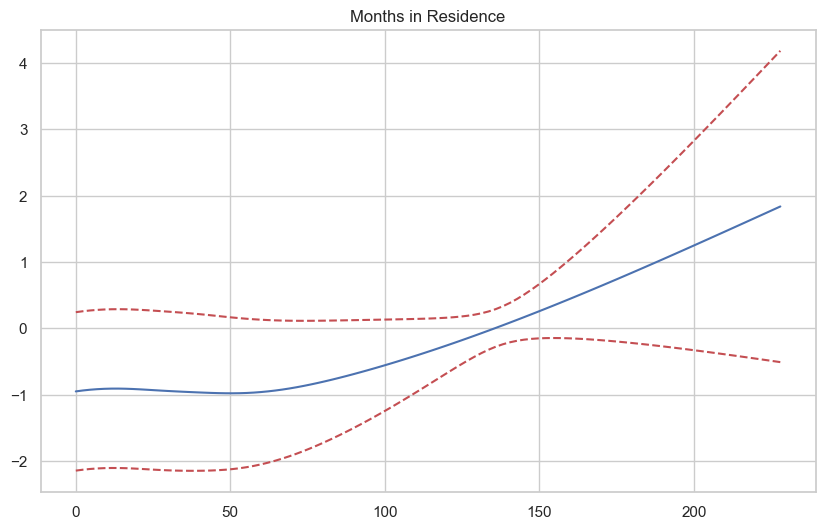

In [31]:
# Plotting partial dependence for the 'MONTHS_IN_RESIDENCE' variable

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
i = 2
XX = gam.generate_X_grid(term=i)
pdep, confi = gam.partial_dependence(term=i, width=0.95)

ax.plot(XX[:, i], pdep)
ax.plot(XX[:, i], confi, c="r", ls="--")

ax.set_title("Months in Residence")
plt.show()

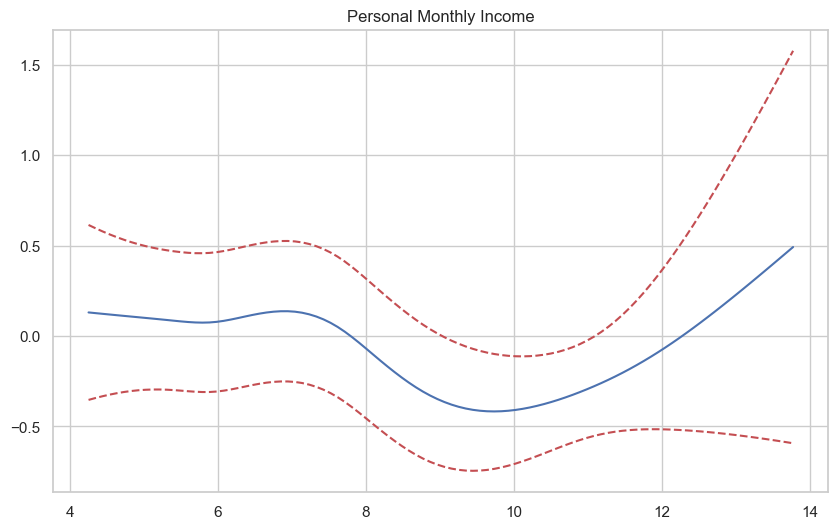

In [32]:
# Plotting partial dependence for the 'LOG_PERSONAL_MONTHLY INCOME' variable

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
i = 3
XX = gam.generate_X_grid(term=i)
pdep, confi = gam.partial_dependence(term=i, width=0.95)

ax.plot(XX[:, i], pdep)
ax.plot(XX[:, i], confi, c="r", ls="--")

ax.set_title("Personal Monthly Income")
plt.show()

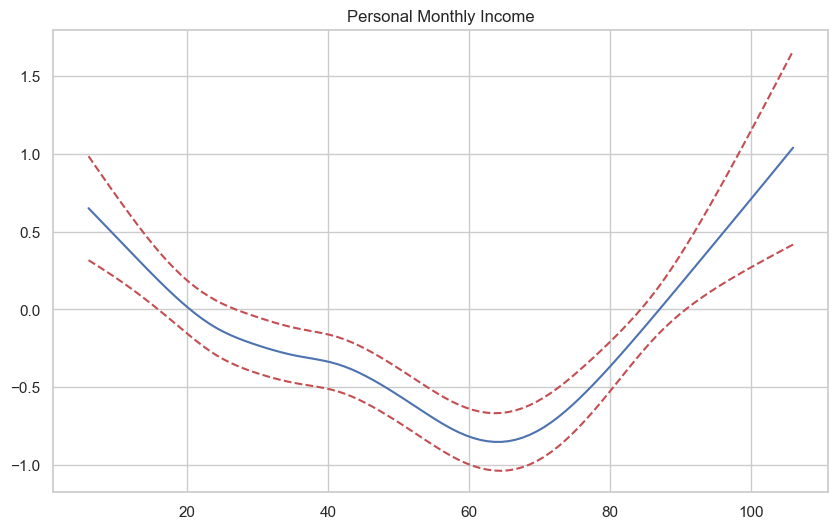

In [33]:
# Plotting partial dependence for the 'AGE' variable

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
i = 5
XX = gam.generate_X_grid(term=i)
pdep, confi = gam.partial_dependence(term=i, width=0.95)

ax.plot(XX[:, i], pdep)
ax.plot(XX[:, i], confi, c="r", ls="--")

ax.set_title("Personal Monthly Income")
plt.show()

### Exercise 10

How does the partial correlation with respect to age look?

> The partial correlation plot for age shows an uneven decline up to the age of approximately 50, after which there is a steep increase. This suggests that the risk of default is higher for younger individuals, but then decreases as they age, before rising again in later years. This pattern is consistent with the life cycle hypothesis, which posits that individuals tend to borrow more when they are young, and then pay off their debts as they age and accumulate wealth.
> However, it is important to consider that it may not be as steep of an incline as the plot suggests as the confidence interval broadens towards the end of the graph. Furthermore, according to intuition (and some research), the risk of default increases at a much lower rate as individuals age, and the steep incline in the plot may be an artifact of the model's assumptions.

### Exercise 11

Refit your model, but this time impose [monotonicity or concavity/convexity](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Penalties-/-Constraints) on the relationship between age and credit risk (which makes more sense to you?). Fit the model and plot the new partial dependence.

> For the question, we decided to impose convexity as a constraint on the relationship between age and credit risk. This is because of the intuition that credit risk tends to exhibit diminishing returns as an individual grows older. Therefore, convexity would ensure that the predicted risk associated with older individuals increases at a decreasing rate. Overall, this will help in getting a smoother and more interpretable relationship between age and credit risk. 

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:04 ETA:   0:00:41
 18% (2 of 11) |####                     | Elapsed Time: 0:00:06 ETA:   0:00:22
 27% (3 of 11) |######                   | Elapsed Time: 0:00:09 ETA:   0:00:20
 36% (4 of 11) |#########                | Elapsed Time: 0:00:11 ETA:   0:00:15
 45% (5 of 11) |###########              | Elapsed Time: 0:00:13 ETA:   0:00:11
 54% (6 of 11) |#############            | Elapsed Time: 0:00:14 ETA:   0:00:08
 63% (7 of 11) |###############          | Elapsed Time: 0:00:16 ETA:   0:00:08
 72% (8 of 11) |##################       | Elapsed Time: 0:00:19 ETA:   0:00:07
 81% (9 of 11) |####################     | Elapsed Time: 0:00:22 ETA:   0:00:05
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:24 ETA:   0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:26 Time:  0:00:26


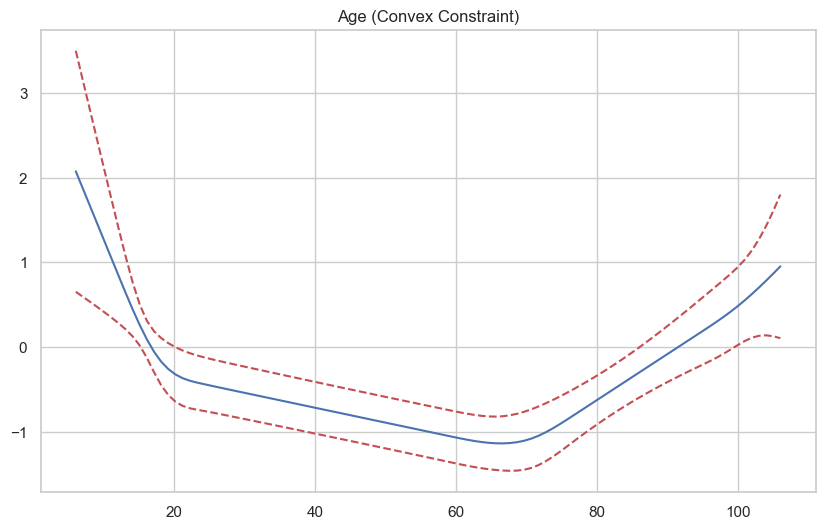

In [34]:
# Fit the model with constraints
gam_convex = LogisticGAM(
    f(0)
    + f(1)
    + s(2)
    + s(3)
    + f(4)
    + s(5, constraints="convex")
    + f(6)
    + f(7)
    + f(8)
    + f(9)
).gridsearch(X_train_np, y_train_np)

# Plot the new partial dependence
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
i = 5
XX = gam_convex.generate_X_grid(term=i)
pdep, confi = gam_convex.partial_dependence(term=i, width=0.95)

ax.plot(XX[:, i], pdep)
ax.plot(XX[:, i], confi, c="r", ls="--")

ax.set_title("Age (Convex Constraint)")
plt.show()

### Exercise 12

Functional form constraints are often about fairness or meeting regulatory requirements, but they can also prevent overfitting.

Does this change the number of "true negatives" you can enroll below a false omission rate of 19%?

### First, getting an idea of the false omission rate:

In [35]:
# Use the trained model (with constraints) to predict labels for the test data
y_pred_convex = gam_convex.predict(X_test)

# Create a confusion matrix for new model
conf_matrix_convex = confusion_matrix(y_test, y_pred_convex)

# Extract true negatives (TN) and false negatives (FN) from the confusion matrix
TN_convex = conf_matrix_convex[0, 0]
FN_convex = conf_matrix_convex[1, 0]

# Calculate False Omission Rate (FOR)
FOR_convex = FN_convex / (FN_convex + TN_convex)

# Calculate the number of "good bets" (true negatives)
good_bets_convex = TN_convex

# Print the results
print("Confusion Matrix:")
print(conf_matrix_convex)
print("\nNumber of 'good bets' (True Negatives):", good_bets_convex)
print("False Omission Rate (FOR):", FOR_convex)

Confusion Matrix:
[[5474    1]
 [1919    6]]

Number of 'good bets' (True Negatives): 5474
False Omission Rate (FOR): 0.25956986338428245


> ### Interpretation: 
> The false omission rate (FOR) measures the proportion of actual good bets that were incorrectly classified as bad bets. A lower FOR indicates better performance in correctly identifying good bets. When comparing the original model with the new model that had the constraint, we can see that the number of false negatives is higher in the latter. Therefore, the false omission rate is lower with the added constraint to the model. This suggests slightly better performance at correctly identifying good bets compared to the first model. 
> 

### Now, checking if the number of true negatives that could be enrolled has changed:

In [36]:
# Extract probabilities for the positive class
predicted_probabilities_convex = gam_convex.predict_proba(X_test)
positive_probabilities_convex = predicted_probabilities_convex

# Initialize variables
for_tolerance = 0.19
best_threshold = None
max_tn = 0
acceptable_fnr = float("inf")

# Iterate over possible thresholds to find the optimal one
for threshold in np.linspace(0, 1, 101):
    # Convert probabilities to binary predictions based on the current threshold
    y_pred_threshold = (positive_probabilities_convex >= threshold).astype(int)

    # Calculate confusion matrix and derive TN, FP, FN, TP
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred_threshold).ravel()

    # Calculate False Negative Rate (FNR)
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0

    # Update best threshold if conditions are met
    if TN > max_tn and FNR <= for_tolerance:
        best_threshold = threshold
        max_tn = TN
        acceptable_fnr = FNR

# Print the results
if best_threshold is not None:
    print(f"Optimal Threshold: {best_threshold}")
    print(f"Maximized True Negatives (Good Bets) at this level: {max_tn}")
    print(f"False Negative Rate at this threshold: {acceptable_fnr * 100:.2f}%")
else:
    print("No threshold found that meets the FNR tolerance.")

Optimal Threshold: 0.21
Maximized True Negatives (Good Bets) at this level: 1401
False Negative Rate at this threshold: 15.53%


> As we can see, the optimal threshold has stayed consistent at 0.21. However, the number of true negatives that can be enrolled below a false omission rate threshold of 19% has increased from 1381 to 1402. The false negative rate has also increased from 15.06% to 15.53%. However, this still falls within the stakeholder's threshold of 19%, therefore, showing that the convexity constraint may be good for the model. 

### Exercise 13

In the preceding exercises, we allowed pyGAM to choose its own smoothing parameters / coefficient penalties. This makes life easy, but it isn't always optimal, especially because when it does so, it picks the same smoothing penalty (the `lambda` in `.summary()`) for all terms.

(If you haven't seen them let, penalities are designed to limit overfitting by, basically, "penalizing" big coefficients on different terms. This tends to push models towards smoother fits.)

[To get around this, we can do a grid or random search.](https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Automatically-tune-the-model) This is definitely a little slow, but let's give it a try!

Then following the model given in the docs linked above, let's do a random search. Make sure your initial random points has a shape of `100 x (the number of terms in your model)`.

In [37]:
# Define the search space for smoothing parameters for RANDOM SEARCH
# Random points on [0, 1], then shift to [-3, 3]
lams = np.random.rand(100, 10) * 6 - 3
lams = 10**lams  # Transform values to [1e-3, 1e3]

# Fit the model with a random search for smoothing parameters
gam_random = LogisticGAM(
    f(0) + f(1) + s(2) + s(3) + f(4) + s(5) + f(6) + f(7) + f(8) + f(9)
).gridsearch(X_train_np, y_train_np, lam=lams)

# Print model summary
print(gam_random.summary())

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:27
  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:02:00
  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:58
  4% (4 of 100) |                        | Elapsed Time: 0:00:05 ETA:   0:02:08
  5% (5 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:59
  6% (6 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:02:16
  7% (7 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:01:58
  8% (8 of 100) |#                       | Elapsed Time: 0:00:09 ETA:   0:01:47
  9% (9 of 100) |##                      | Elapsed Time: 0:00:10 ETA:   0:01:29
 10% (10 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:42
 11% (11 of 100) |##                     | Elapsed Time: 0:00:13 ETA:   0:02:05
 12% (12 of 100) |##                     | Elapsed Time: 0:00:15 ETA:   0:02:05
 13% (13 of 100) |##                    

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     34.5631
Link Function:                        LogitLink Log Likelihood:                                -16636.7748
Number of Samples:                        29599 AIC:                                            33342.6758
                                                AICc:                                           33342.7637
                                                UBRE:                                               3.1274
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0182
Feature Function                  Lam

### Exercise 14

How many true negatives can you get now at a less than 19% False Omission Rate?

In [38]:
y_pred_random = gam_random.predict_proba(X_test)
positive_probabilities_random = y_pred_random

# Initialize variables
for_tolerance = 0.19
best_threshold = None
max_tn = 0
acceptable_fnr = float("inf")

# Iterate over possible thresholds to find the optimal one
for threshold in np.linspace(0, 1, 101):
    # Convert probabilities to binary predictions based on the current threshold
    y_pred_threshold = (positive_probabilities_random >= threshold).astype(int)

    # Calculate confusion matrix and derive TN, FP, FN, TP
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred_threshold).ravel()

    # Calculate False Negative Rate (FNR)
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0

    # Update best threshold if conditions are met
    if TN > max_tn and FNR <= for_tolerance:
        best_threshold = threshold
        max_tn = TN
        acceptable_fnr = FNR

# Print the results
if best_threshold is not None:
    print(f"Optimal Threshold: {best_threshold}")
    print(f"Maximized True Negatives (Good Bets) at this level: {max_tn}")
    print(f"False Negative Rate at this threshold: {acceptable_fnr * 100:.2f}%")
else:
    print("No threshold found that meets the FNR tolerance.")

Optimal Threshold: 0.21
Maximized True Negatives (Good Bets) at this level: 1382
False Negative Rate at this threshold: 15.27%


> Using the random search, we can see that the number of true negatives, or 'good bets' we can enroll under the False Omission Rate threshold of 19% has gone up to 1393. While the false negative rate has gone up to 15.38% (from 15.06% in the base model and 14.81% in the model with the added convexity constraint), this still falls well below the 19% threshold given by the stakeholder. 

### Exercise 15

Add an interaction term between age and personal income.

In [39]:
# Importing the necessary module from pygam
from pygam import te

# Adding an interaction term between age and personal income
gam_interaction = LogisticGAM(
    f(0)
    + f(1)
    + s(2)
    + s(3)
    + f(4)
    + s(5, constraints="convex")
    + f(6)
    + f(7)
    + f(8)
    + f(9)
    + te(4, 2)
).gridsearch(X_train_np, y_train_np)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:08 ETA:   0:01:25
 18% (2 of 11) |####                     | Elapsed Time: 0:00:15 ETA:   0:01:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:20 ETA:   0:00:41
 36% (4 of 11) |#########                | Elapsed Time: 0:00:24 ETA:   0:00:25
 45% (5 of 11) |###########              | Elapsed Time: 0:00:27 ETA:   0:00:20
 54% (6 of 11) |#############            | Elapsed Time: 0:00:30 ETA:   0:00:12
 63% (7 of 11) |###############          | Elapsed Time: 0:00:33 ETA:   0:00:15
 72% (8 of 11) |##################       | Elapsed Time: 0:00:38 ETA:   0:00:13
 81% (9 of 11) |####################     | Elapsed Time: 0:00:41 ETA:   0:00:06
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:45 ETA:   0:00:03
100% (11 of 11) |########################| Elapsed Time: 0:00:49 Time:  0:00:49


### Exercise 16

Now visualize the [partial dependence interaction term.](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Terms-and-Interactions)

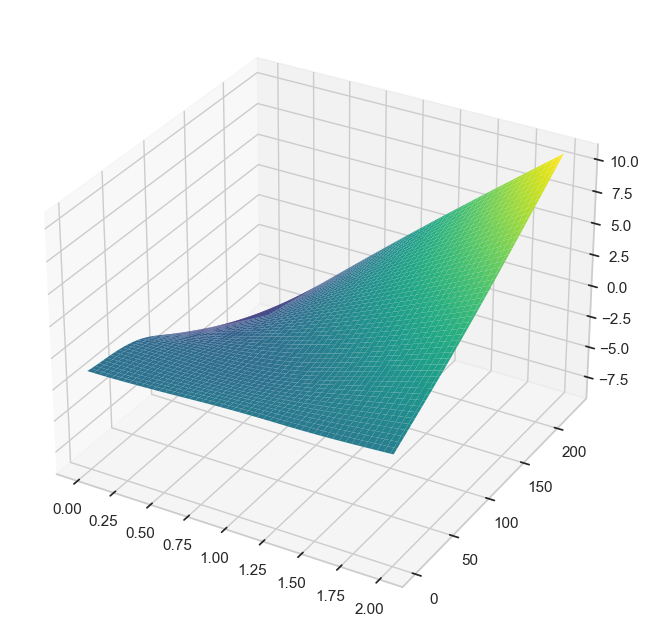

In [40]:
# Visualizing the partial dependence of the interaction term

# Importing mpl_toolkits for 3D plotting
from mpl_toolkits import mplot3d

plt.ion()
plt.rcParams["figure.figsize"] = (12, 8)

# Create a 3D plot for the interaction term
XX = gam_interaction.generate_X_grid(term=10, meshgrid=True)
Z = gam_interaction.partial_dependence(term=10, X=XX, meshgrid=True)

ax = plt.axes(projection="3d")
ax.plot_surface(XX[0], XX[1], Z, cmap="viridis", edgecolor="none")
plt.show()

### Exercise 17

Finally, another popular interpretable model is the `ExplainableBoostingClassifier`. You can learn more [about it here](https://interpret.ml/docs/ebm.html), though how much sense it will make to you may be limited if you aren't familiar with gradient boosting yet. Still, at least one of your classmates prefers it to pyGAM, so give it a try using this code:


```python
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
   warnings.simplefilter("ignore")

   ebm_global = ebm.explain_global()
   show(ebm_global)

   ebm_local = ebm.explain_local(X_train, y_train)
   show(ebm_local)
```

In [42]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    ebm_global = ebm.explain_global()
    show(ebm_global)

    ebm_local = ebm.explain_local(X_train, y_train)
    show(ebm_local)

<!-- http://127.0.0.1:7001/12091721744/ -->

<!-- http://127.0.0.1:7001/12047588176/ -->